# Kernel Density Estimation with Python (BigDIPA 2016)

**A tutorial using Python and scientific libraries to run kernel density estimation (KDE) of simulated images on a personal computer.**

By Jihyun Park (`jihyunp@ics.uci.edu`)<br/>
Department of Computer Science, University of California, Irvine

October 27, 2016

## Outline
-------------------------
Kernel density estimation (KDE) is a non-parametric way to estimate the probability density function.
It takes a finite sample of data and make inferences about the underlying probability density function everywhere.

The lab consists of two parts:
### Part 1
- Simulate 2-D data
- Estimate probability density using KDE (`KernelDensity` package from scikit-learn)
- Bandwidth Selection (Manual, Automated)
- Contour plot, scatter plot

### Part 2
- Repeat the part 1 with different simulated data (Exercise for you!)
- Use Bayes theorem to calculate and plot posterior probabilities



## Requirements
--------------------------------
- Basic knowledge of probability.
- Familiarity with programming and nD array computing (e.g. working with matrices in Matlab or numpy in python).
- Python 3.5 or Python 2.7 with libraries : Jupyter (for ipython notebook), numpy, scipy, scikit-learn, matplotlib.
- It is recommended to have the newest version of libraries installed.

## References
----------------------------------
- [Scikit-learn Density Estimation](http://scikit-learn.org/stable/modules/density.html) : Description and examples on density estimation including KDE.
- [Scikit-learn KDE Package Documentation](http://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KernelDensity.html) : `KernelDensity` class documentation.

## Before We Start : Import Packages
-----------------------------

You can import the packages anytime before using the package, but we are importing them before we start to make sure you have all the packages that we need.

In [3]:
import numpy as np
from numpy.random import binomial, multivariate_normal, uniform, seed

from scipy import stats
from scipy.linalg import sqrtm, det, inv

from sklearn.datasets import fetch_species_distributions
from sklearn.datasets.species_distributions import construct_grids
from sklearn.neighbors import KernelDensity
# from sklearn.model_selection import GridSearchCV
from sklearn.grid_search import GridSearchCV # if you have older version of sklearn

import matplotlib.pyplot as plt
%matplotlib inline

If you get an **`ImportError`** for **`model_selection`**, 
update your **`scikit-learn`** using one of these commands below in terminal window.

- `$conda install scikit-learn` : If you installed python through anaconda
- `$pip install -U scikit-learn`

Or, you can try importing **`GridSearchCV`** from **`sklearn.grid_search`** package.

- `from sklearn.grid_search import GridSearchCV`

# PART 1
--------------------
## 1. Data

## 1.1 Simulate data

Randomly generate data from 5 Gaussians. 

In [4]:
# 50 X 50 image with 5 Gaussians
nX = 50
nY = nX
n_gaussians = 5

# Generate the same data by setting the seed
seed(135)

# Initialize
Xdata = np.zeros((0,2))
true_means = np.zeros((0,2))
true_covs = []
true_Ns = []

for i in range(n_gaussians):
    mean = uniform(5, nX-5, size=2)
    var = uniform(3, 80)
    cov_mat = np.array([[var, 0],[0, var]])
    n_sample = int(round(uniform(30,60)))
    # Generate data points
    d = multivariate_normal(mean, cov_mat, size=n_sample)
    # Update the variables
    Xdata = np.concatenate((Xdata, d), axis=0)
    true_means = np.concatenate((true_means, mean[np.newaxis,:]), axis=0)
    true_covs.append(cov_mat)
    true_Ns.append(n_sample)

## 1.2 Plot generated data

/Users/jihyun/anaconda3/lib/python3.5/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')
/Users/jihyun/anaconda3/lib/python3.5/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


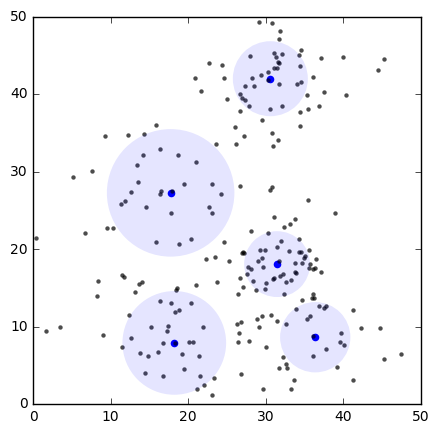

In [5]:
# Plot true mean and var
fig, ax = plt.subplots(figsize=(5,5))
for i in range(n_gaussians):
    # std as circle
    circle = plt.Circle(true_means[i,:], np.sqrt(true_covs[i][0,0]), alpha=0.1, linewidth=0)
    ax.add_artist(circle)
    # means as dot
    ax.scatter(true_means[i,0], true_means[i,1], s=30, linewidth=0)
    ax.set_xlim(0,nX)
    ax.set_ylim(0,nY)

# Plot the data points
ax.scatter(Xdata[:,0], Xdata[:,1], s=10, color='black', alpha=0.7, linewidth=0)

### Grid arrays
Before we plot the density, we will generate arrays for grids. This is because we want a density value for each grid location. We're going to generate 100 X 100 mesh grid. If you want to make the grid denser, change the number for **`ngrid`** in the below code to something larger.

After generating the mesh grid, we're going to flatten the matrix to have (N x 2) shape so that it can be used as input for other functions. <br\> 
The variables **`X, Y, xy, `**and **`ngrid`**  will be used throughout the lab. 

In [6]:
# Generate Mesh Grid for Plotting (50 x 50 matrix)
ngrid = 100
xgrid = np.linspace(-25, 75, ngrid)
ygrid = np.linspace(-25, 75, ngrid)

X, Y = np.meshgrid(xgrid, ygrid) # Now we have (50 X 50) matrix

# ravel() function flattens (50 x 50) matrix -> (1 x 2500) array
xy = np.vstack([Y.ravel(), X.ravel()]).T
xy.shape  # Print the shape!

(10000, 2)

## 1.3 Plot the true probability density for the simulated data
This is the true (ideal) density plotted as contour plot. Using KDE with simulated data points, we want estimated density close to this.

(0, 50)

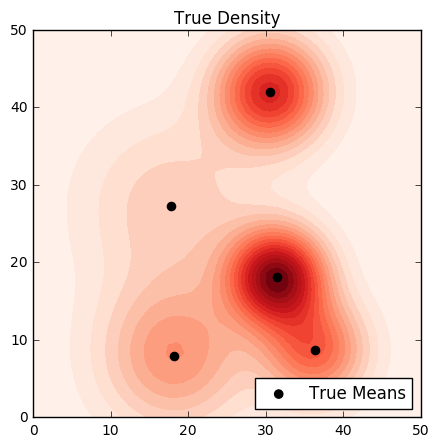

In [7]:
# Mixture weights are inferred from the number of data points.
total_N = float(sum(true_Ns))
true_prob = np.zeros((xy.shape[0]))
for m, c, n in zip(true_means, true_covs, true_Ns):
    true_prob += stats.multivariate_normal.pdf(xy, m, c) * n / total_N
true_prob = true_prob.reshape((ngrid,ngrid), order='F')

fig, ax = plt.subplots(figsize=(5,5))
ax.contourf(X, Y, true_prob,
            levels=np.linspace(true_prob.min(), true_prob.max(), 20), cmap='Reds')
ax.scatter(true_means[:,0], true_means[:,1], s=35, c='black', label="True Means")

ax.legend(loc='lower right', scatterpoints=1)
ax.set_title('True Density')
ax.set_xlim(0,nX)
ax.set_ylim(0,nY)

## 2. Define a wrapper function that runs KDE

Now define a wrapper function that runs KDE and returns the evaluated density in (50 X 50) matrix form. <br/>
It is better to define a wrapper function since this will be used a lot!

In [8]:
def run_kde(Xdata, bandwidth, metric, kernel):
    """ Construct a KernelDensity object, fit with the data points we generated, 
        and then return the evaluated density for the (50 X 50) mesh grid """
    # Construct a kernel density object
    kde = KernelDensity(bandwidth=bandwidth, metric=metric, kernel=kernel)
    kde.fit(Xdata)
    # kde.score_samples() returns values in log scale
    phat = np.exp(kde.score_samples(xy))
    phat = phat.reshape((ngrid, ngrid), order='F')
    return phat

## 3. Plot the estimated density with true means

Now run the function defined above, and plot the estimated density $\hat{p}(x)$ as contour plot. 
We're going to use Euclidean distance (`metric='euclidean`) and Gaussian kernel (`kernel='gaussian'`), and change the size of the bandwidth to see the difference in the result. <br/>
(You can also try with different metrics or kernels : more information at [Scikit-learn KernelDensity](http://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KernelDensity.html))

## 3.1 Small bandwidth

(0, 50)

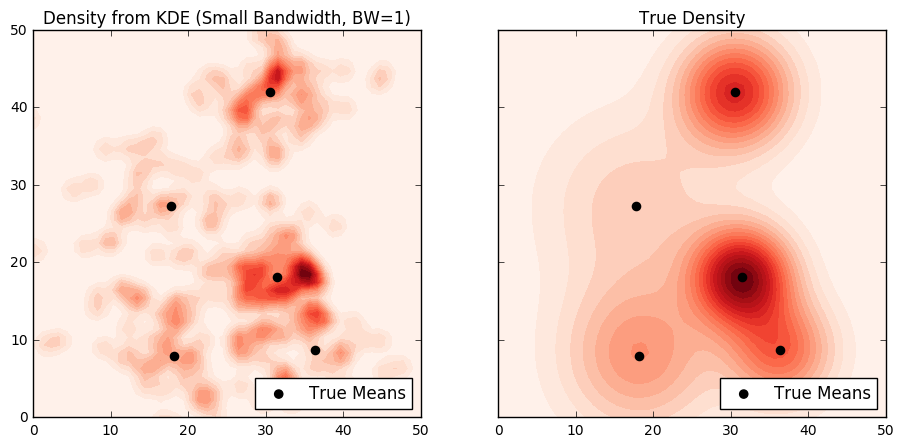

In [9]:
# Get estimated density from KDE
phat = run_kde(Xdata, bandwidth=1, metric='euclidean', kernel='gaussian')

fig, axs = plt.subplots(1,2,figsize=(11,5), sharex=True, sharey=True)

# plot estimated probability density from KDE
ax = axs[0]
levels = np.linspace(phat.min(), phat.max(), 20)
im = ax.contourf(X, Y, phat, levels=levels, cmap='Reds')
ax.scatter(true_means[:,0], true_means[:,1], s=35, c='black', label="True Means")
ax.legend(loc='lower right', scatterpoints=1)
ax.set_title('Density from KDE (Small Bandwidth, BW=1)')

# Plot for true probability density
ax = axs[1]
ax.contourf(X, Y, true_prob,
            levels=np.linspace(true_prob.min(), true_prob.max(), 20), cmap='Reds')
ax.scatter(true_means[:,0], true_means[:,1], s=35, c='black', label="True Means")
ax.legend(loc='lower right', scatterpoints=1)
ax.set_title('True Density')
ax.set_xlim(0,nX)
ax.set_ylim(0,nY)

## 3.2 Large bandwidth

(0, 50)

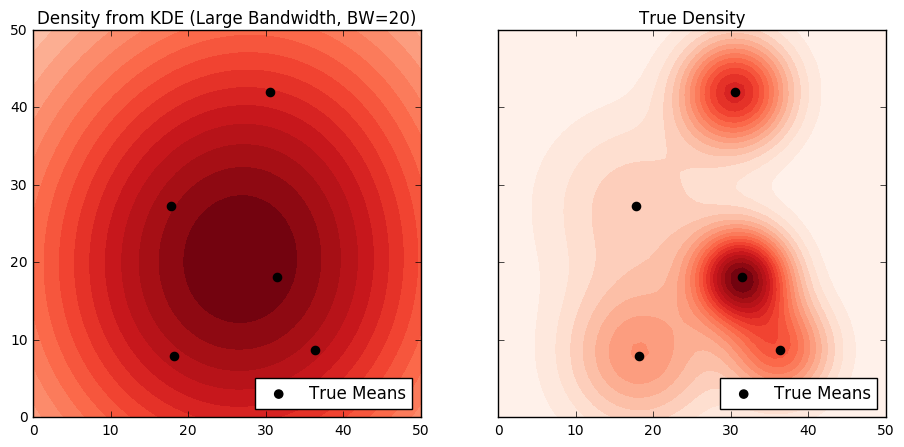

In [10]:
# Get estimated density from KDE
phat = run_kde(Xdata, bandwidth=20, metric='euclidean', kernel='gaussian')

fig, axs = plt.subplots(1,2,figsize=(11,5), sharex=True, sharey=True)

# plot estimated probability density from KDE
ax = axs[0]
levels = np.linspace(phat.min(), phat.max(), 20)
im = ax.contourf(X, Y, phat, levels=levels, cmap='Reds')
ax.scatter(true_means[:,0], true_means[:,1], s=35, c='black', label="True Means")
ax.legend(loc='lower right', scatterpoints=1)
ax.set_title('Density from KDE (Large Bandwidth, BW=20)')


# Plot for true probability density
ax = axs[1]
ax.contourf(X, Y, true_prob,
            levels=np.linspace(true_prob.min(), true_prob.max(), 20), cmap='Reds')
ax.scatter(true_means[:,0], true_means[:,1], s=35, c='black', label="True Means")
ax.legend(loc='lower right', scatterpoints=1)
ax.set_title('True Density')
ax.set_xlim(0,nX)
ax.set_ylim(0,nY)

## 3.3 Manually Selected Bandwidth

Try running with different size of bandwidths to find the best bandwidth! Modify the variable **`selected_bw`** in the below code.

(0, 50)

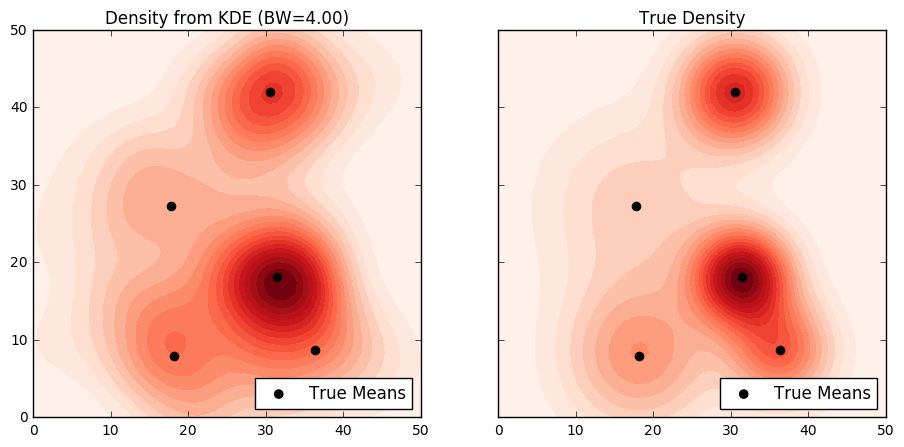

In [11]:
# Get estimated density from KDE
selected_bw = 4;"""Appropriate bandwidth size"""

phat = run_kde(Xdata, bandwidth=selected_bw, metric='euclidean', kernel='gaussian')

fig, axs = plt.subplots(1,2,figsize=(11,5), sharex=True, sharey=True)

# plot estimated probability density from KDE
ax = axs[0]
levels = np.linspace(phat.min(), phat.max(), 20)
im = ax.contourf(X, Y, phat, levels=levels, cmap='Reds')
ax.scatter(true_means[:,0], true_means[:,1], s=35, c='black', label="True Means")
ax.legend(loc='lower right', scatterpoints=1)
ax.set_title('Density from KDE (BW=%.2f)' % selected_bw)


# Plot for true probability density
ax = axs[1]
ax.contourf(X, Y, true_prob,
            levels=np.linspace(true_prob.min(), true_prob.max(), 20), cmap='Reds')
ax.scatter(true_means[:,0], true_means[:,1], s=35, c='black', label="True Means")
ax.legend(loc='lower right', scatterpoints=1)
ax.set_title('True Density')
ax.set_xlim(0,nX)
ax.set_ylim(0,nY)

## 4. Automated Bandwidth Selection

Cross-validation can be used to select the bandwidth automatically. Cross-validation is a model validation technique for assessing how the results will generalize to an independent data set. In K-fold cross-validation, randomized data are splitted into K sets, and K-1 sets are used for estimating the density (train set) and 1 set is used for evaluation (validation set). We do this for K times, and score is calculated for the validation set at each run. The overall cross-validation score is the mean of the M scores. (More info: [Wikipedia: Cross-validation](https://en.wikipedia.org/wiki/Cross-validation_%28statistics%29))

Scikit-learn has a nice package called **`GridSearchCV`** that does all the job for us! It uses **`score()`** function in the object to calculate the score. **`KernelDensity`** class has a function **`score(valX)`** that returns the total log probability of the validation data **`valX`** under the model. **`GridSearchCV`** will calculate the cross-validation score for each bandwidth value, and then return the bandwidth that gave the highest score.

We will use 10-fold cross-validation.

In [13]:
grid = GridSearchCV(KernelDensity(metric='euclidean', kernel='gaussian'),
                    {'bandwidth': np.linspace(0.5, 10, 50)}, cv=10) # 10-fold cross-validation
grid.fit(Xdata)
print(grid.best_params_)
bw_cv = grid.best_params_['bandwidth'] # Bandwidth value saved in 'bw'

{'bandwidth': 4.1836734693877551}


(0, 50)

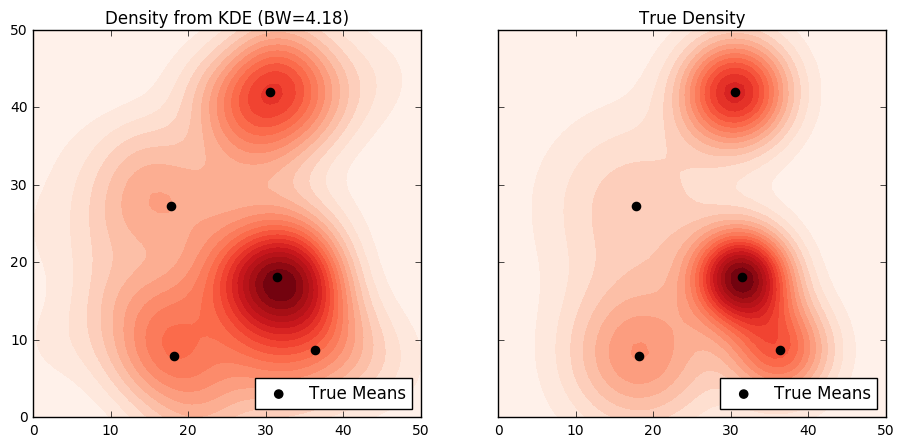

In [14]:
# Get estimated density from KDE
phat = run_kde(Xdata, bandwidth=bw_cv, metric='euclidean', kernel='gaussian')

fig, axs = plt.subplots(1,2,figsize=(11,5), sharex=True, sharey=True)

# plot estimated probability density from KDE
ax = axs[0]
levels = np.linspace(phat.min(), phat.max(), 20)
im = ax.contourf(X, Y, phat, levels=levels, cmap='Reds')
ax.scatter(true_means[:,0], true_means[:,1], s=35, c='black', label="True Means")
ax.legend(loc='lower right', scatterpoints=1)
ax.set_title('Density from KDE (BW=%.2f)' % bw_cv)


# Plot for true probability density
ax = axs[1]
ax.contourf(X, Y, true_prob,
            levels=np.linspace(true_prob.min(), true_prob.max(), 20), cmap='Reds')
ax.scatter(true_means[:,0], true_means[:,1], s=35, c='black', label="True Means")

ax.legend(loc='lower right', scatterpoints=1)
ax.set_title('True Density')
ax.set_xlim(0,nX)
ax.set_ylim(0,nY)

# PART 2 
--------------------
In this part, we will generate two different data from two different Gaussian functions. 


### Drawing Ellipse
We will define a function that returns a list of (x,y) pairs for an ellipse. This will be used for plotting the standard deviation of Gaussian function.

In [15]:
# Helper function (For Drawing ellipse)
def get_ellipse(mean, cov_mat):
    theta = np.linspace(0,2*np.pi,100)
    circle = np.array([np.sin(theta), np.cos(theta)]).T
    ell = np.dot(circle, sqrtm(cov_mat))
    ell = ell + np.tile(mean, (ell.shape[0],1))
    return ell

## 1. Gaussian 1 (Red)
Generate data from a single 2-D Gaussian, and store the information in a dictionary.

In [16]:
seed(1)
m = np.array([35, 35])
cov = np.array([[50,30],[30,50]])
N = 120
data = multivariate_normal(m, cov, size=N)
Gaussian1 = {'mean':m, 'cov':cov, 'N':N, 'data':data}

Plot the data points with its true mean and standard deviation.

(0, 50)

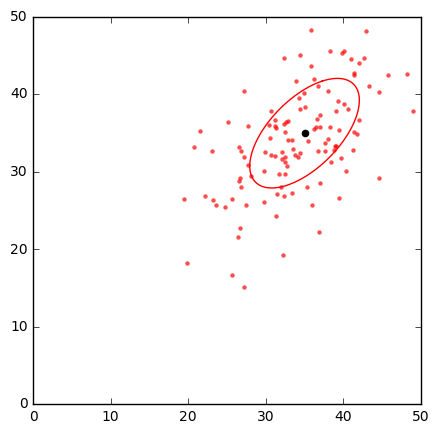

In [17]:
fig, ax = plt.subplots(figsize=(5,5))

ax.scatter(Gaussian1['mean'][0], Gaussian1['mean'][1], s=30, color='black', linewidth=0)
ell1 = get_ellipse(Gaussian1['mean'], Gaussian1['cov'])
ax.plot(ell1[:,0], ell1[:,1], color='red')
# Plot the data points
ax.scatter(Gaussian1['data'][:,0], Gaussian1['data'][:,1], s=10, color='red', alpha=0.7, linewidth=0)

ax.set_xlim(0,nX)
ax.set_ylim(0,nY)

### EXERCISE
Run KDE and plot the estimated density as contour plot for **`Gaussian1`**. Select a proper bandwidth size using automated bandwidth selection.  Fill in the parts that are missing (parts that are commented out with three double quotes : `"""`).

In [18]:
"""Use GridSearchCV to find the most appropriate bandwidth size (Search from 1 to 6)"""
grid = GridSearchCV(KernelDensity(metric='euclidean', kernel='gaussian'),
                    {'bandwidth': np.linspace(1, 6, 50)}, cv=10) # 10-fold cross-validation
grid.fit(Gaussian1['data'])
print(grid.best_params_)
bw_red = grid.best_params_['bandwidth'] # """ """

{'bandwidth': 3.3469387755102042}


(0, 50)

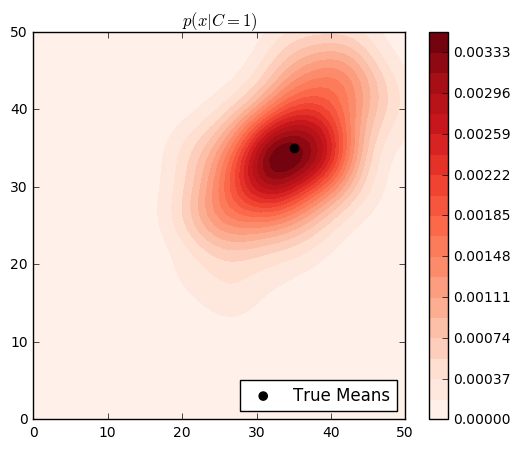

In [19]:
phat_red = run_kde(Gaussian1['data'], bandwidth=bw_red, metric='euclidean', kernel='gaussian')#"""Fill in this part""")

# plot contours of the density
fig, ax = plt.subplots(figsize=(6,5))
levels = np.linspace(phat_red.min(), phat_red.max(), 20)
im = ax.contourf(X, Y, phat_red, levels=levels, cmap='Reds')
fig.colorbar(im)

ax.scatter(Gaussian1['mean'][0], Gaussian1['mean'][1], s=35, c='black', label="True Means")
ax.legend(loc='lower right', scatterpoints=1)
ax.set_title('$p(x|C=1)$')
ax.set_xlim(0,nX)
ax.set_ylim(0,nY)

## 2. Gaussian 2 (Blue)
Generate data from a single 2-D Gaussian, and store the information in a dictionary.

In [20]:
# Gaussian 2
seed(1)
m = np.array([20, 20])
cov = np.array([[55,20],[20,55]])
N = 150
data = multivariate_normal(m, cov, size=N)
Gaussian2 = {'mean':m, 'cov':cov, 'N':N, 'data':data}

Plot the data points with mean and standard deviation.

(0, 50)

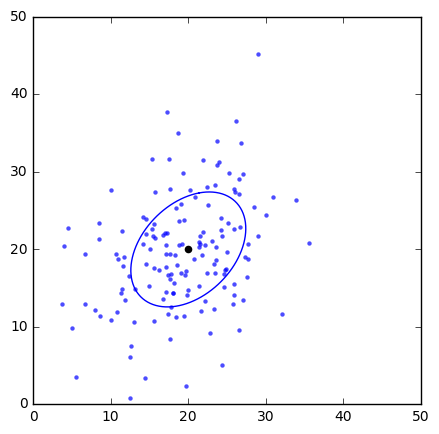

In [21]:
# Plot the data
fig, ax = plt.subplots(figsize=(5,5))
ax.scatter(Gaussian2['mean'][0], Gaussian2['mean'][1], s=30, color='black', linewidth=0)
ell2 = get_ellipse(Gaussian2['mean'], Gaussian2['cov'])
ax.plot(ell2[:,0], ell2[:,1], color='blue')

# Plot the data points
ax.scatter(Gaussian2['data'][:,0], Gaussian2['data'][:,1], s=10, color='blue', alpha=0.7, linewidth=0)

ax.set_xlim([0,50])
ax.set_ylim([0,50])

### EXERCISE
Run KDE and plot the estimated density as contour plot for **`Gaussian2`**. Select a proper bandwidth size using automated bandwidth selection.  Fill in the parts that are missing (parts that are commented out with three double quotes : `"""`).

In [22]:
"""Use GridSearchCV to find the most appropriate bandwidth size (Search from 1 to 6)"""
grid = GridSearchCV(KernelDensity(metric='euclidean', kernel='gaussian'),
                    {'bandwidth': np.linspace(1, 6, 50)}, cv=10) # 10-fold cross-validation
grid.fit(Gaussian2['data'])
print(grid.best_params_)
bw_blue = grid.best_params_['bandwidth'] # """ """

{'bandwidth': 3.7551020408163267}


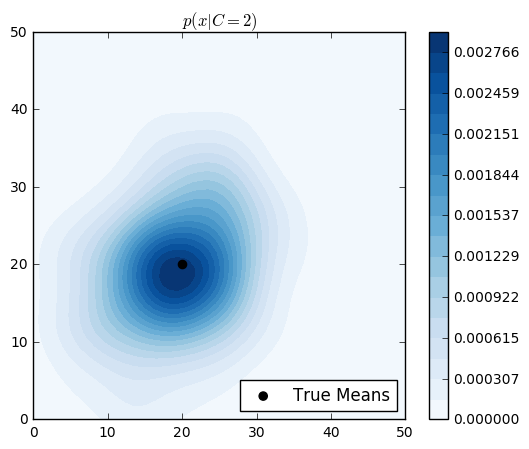

In [23]:
phat_blue =run_kde(Gaussian2['data'], bandwidth=bw_blue, metric='euclidean', kernel='gaussian') #"""Fill in this part""")

# plot contours of the density
fig, ax = plt.subplots(figsize=(6,5))
levels = np.linspace(phat_blue.min(), phat_blue.max(), 20)
im = ax.contourf(X, Y, phat_blue, levels=levels, cmap='Blues')
fig.colorbar(im)

ax.scatter(Gaussian2['mean'][0], Gaussian2['mean'][1], s=35, c='black', label="True Means")
ax.legend(loc='lower right', scatterpoints=1)
ax.set_xlim(0,50)
ax.set_ylim(0,50)
ax.set_title('$p(x|C=2)$')

## 3. Gaussian 1 + Gaussian 2
Now plot both of the data from **`Gaussian1`** and **`Gaussian2`** in the same figure.

(0, 50)

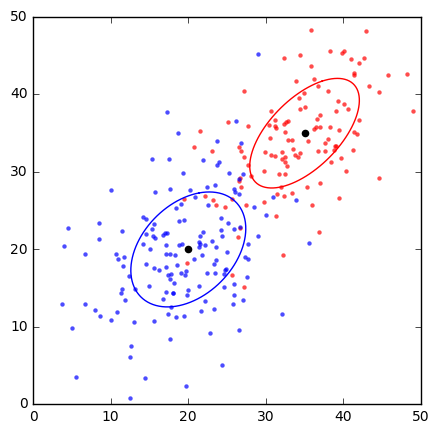

In [24]:
fig, ax = plt.subplots(figsize=(5,5))

# Gaussian 1
ax.scatter(Gaussian1['mean'][0], Gaussian1['mean'][1], s=30, color='black', linewidth=0)
ell = get_ellipse(Gaussian1['mean'], Gaussian1['cov'])
ax.plot(ell[:,0], ell[:,1], color='red')
# Plot the data points
ax.scatter(Gaussian1['data'][:,0], Gaussian1['data'][:,1], s=10, color='red', alpha=0.7, linewidth=0)

# Gaussian 2
ax.scatter(Gaussian2['mean'][0], Gaussian2['mean'][1], s=30, color='black', linewidth=0)
ell = get_ellipse(Gaussian2['mean'], Gaussian2['cov'])
ax.plot(ell[:,0], ell[:,1], color='blue')
# Plot the data points
ax.scatter(Gaussian2['data'][:,0], Gaussian2['data'][:,1], s=10, color='blue', alpha=0.7, linewidth=0)
    
ax.set_xlim([0,50])
ax.set_ylim([0,50])

### EXERCISE
Run KDE and plot the estimated density as contour plot for the data plotted above. Select a proper bandwidth size using manual bandwidth selection.<br/>
For concatenating two different `numpy.ndarray` **`a`** and **`b`**, use **`np.concatenate((a,b))`**.   Fill in the parts that are missing (parts that are commented out with three double quotes : `"""`).

(0, 50)

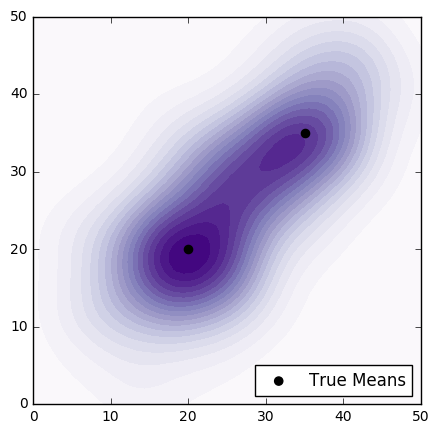

In [25]:
data_total = np.concatenate((Gaussian1['data'], Gaussian2['data']))
phat_total = run_kde(data_total, bandwidth=4, metric='euclidean', kernel='gaussian')

fig, ax = plt.subplots(figsize=(5,5))

levels = np.linspace(phat_total.min(), phat_total.max(), 20)
ax.contourf(X, Y, phat_total, levels=levels, cmap='Purples')
ax.scatter(Gaussian1['mean'][0], Gaussian1['mean'][1], s=35, c='black', label="True Means")
ax.scatter(Gaussian2['mean'][0], Gaussian2['mean'][1], s=35, c='black')
ax.legend(loc='lower right', scatterpoints=1)
ax.set_xlim(0,50)
ax.set_ylim(0,50)

## 4. Posterior probability : Choosing the most likely class

We use posterior probabilities to select a class that is more likely given an input. The **class** is either Gaussian 1 (Red) or Gaussian 2 (Blue). 
Posterior probabilities can be calculated using below equation. Note that the estimated densities in section 1 and 2 correspond to $\hat{p}(x|Red)$ and $\hat{p}(x|Blue)$, respectively. 

$p(Red|x) \propto p(x|Red) \times P(Red)$

$p(Blue|x) \propto p(x|Blue) \times P(Blue)$


If $p(Red|x) > p(Blue|x)$ for a given input $x$, it means that $x$ is more likely to be generated from Gaussian 1 (Red). 

In [26]:
# P(Red), P(Blue) (Priors are inferred from the number of data points)
N_red = Gaussian1['N']
N_blue = Gaussian2['N']
N_total = float(N_red + N_blue)
p_red = N_red/N_total
p_blue = N_blue/N_total

# Calculate Posterior (Note P(X|Red) = phat_red, P(X|Blue) = phat_blue)
p_red_x_ = phat_red * p_red
p_blue_x_ = phat_blue * p_blue
norm_factor = p_red_x_ + p_blue_x_

# Normalize
p_red_x = p_red_x_ / norm_factor
p_blue_x = p_blue_x_ / norm_factor

True posterior probabilities are also calculated. **`scipy.stats.multivariate_normal.pdf()`** was used to generate the true 2-D normal densities. We're going to assume the true priors are the same as the estimated priors.

In [27]:
# True posterior (Assume the same P(red), and P(blue))
p_x_red = stats.multivariate_normal.pdf(xy, Gaussian1['mean'], Gaussian1['cov'])
p_red_x_true_ = p_x_red * p_red

p_x_blue = stats.multivariate_normal.pdf(xy, Gaussian2['mean'], Gaussian2['cov'])
p_blue_x_true_ = p_x_blue * p_blue
norm_factor = p_red_x_true_ + p_blue_x_true_

# Normalize & reshape
p_red_x_true = p_red_x_true_ / norm_factor
p_blue_x_true = p_blue_x_true_ / norm_factor

p_red_x_true = p_red_x_true.reshape((ngrid, ngrid), order='F')
p_blue_x_true = p_blue_x_true.reshape((ngrid, ngrid), order='F')

## Plot $p(Red|x)$

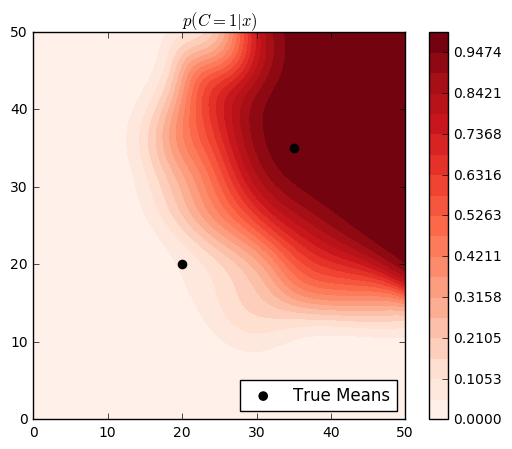

In [28]:
fig, ax = plt.subplots(figsize=(6,5))
levels = np.linspace(p_red_x.min(), p_red_x.max(), 20)
im = ax.contourf(X, Y, p_red_x, levels=levels, cmap='Reds')
fig.colorbar(im)
ax.scatter(Gaussian1['mean'][0], Gaussian1['mean'][1], s=35, c='black', label="True Means")
ax.scatter(Gaussian2['mean'][0], Gaussian2['mean'][1], s=35, c='black')
ax.legend(loc='lower right', scatterpoints=1)
ax.set_xlim(0,nX)
ax.set_ylim(0,nY)
ax.set_title('$p(C=1|x)$')

## Plot $p(Blue|x)$

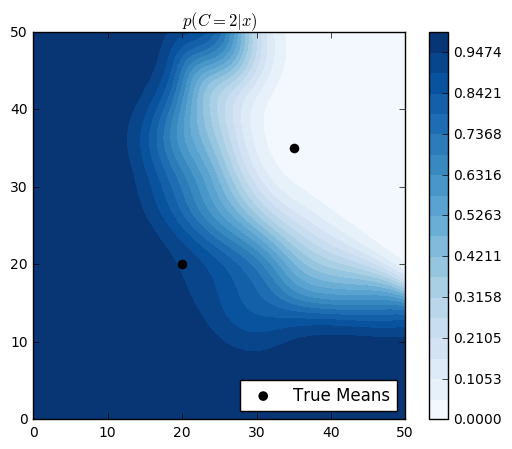

In [29]:
fig, ax = plt.subplots(figsize=(6,5))
levels = np.linspace(p_blue_x.min(), p_blue_x.max(), 20)
im = ax.contourf(X, Y, p_blue_x, levels=levels, cmap='Blues')
fig.colorbar(im)
ax.scatter(Gaussian1['mean'][0], Gaussian1['mean'][1], s=35, c='black', label="True Means")
ax.scatter(Gaussian2['mean'][0], Gaussian2['mean'][1], s=35, c='black')
ax.legend(loc='lower right', scatterpoints=1)
ax.set_xlim(0,nX)
ax.set_ylim(0,nY)
ax.set_title('$p(C=2|x)$')

## Plot the decision boundary

Decision boundary is a boundary when $p(Red|x) = p(Blue|x)$, and since we only have two classes (Red, Blue), this is when $p(Red|x) = p(Blue|x) = 0.5$. 

The first figure is when we plot $p(Blue|x)$ with a different colormap. The white area is when $p(Blue|x) = 0.5$. The second figure has the estimated decision boundary and the true decision boundary overlaid.

(0, 50)

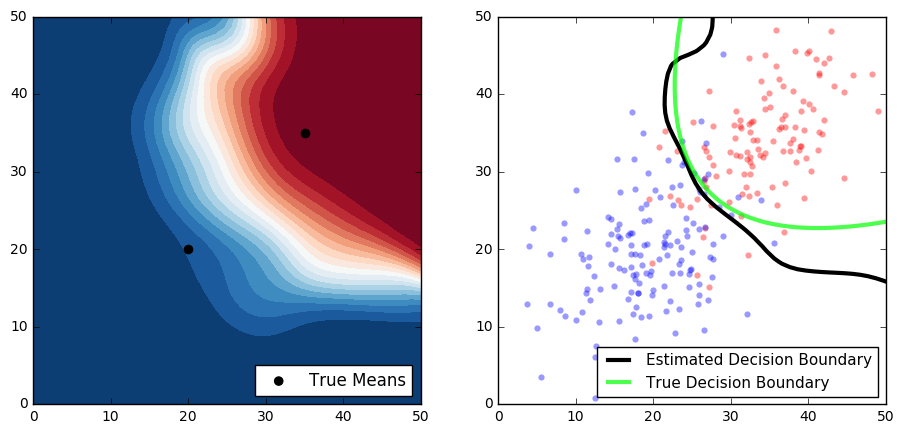

In [30]:
fig, axs = plt.subplots(1,2, figsize=(11,5))

# First subplot
ax = axs[0]
levels = np.linspace(p_blue_x.min(), p_blue_x.max(), 20)
ax.contourf(X, Y, p_blue_x, levels=levels, cmap='RdBu')
ax.scatter(Gaussian1['mean'][0], Gaussian1['mean'][1], s=35, c='black', label="True Means")
ax.scatter(Gaussian2['mean'][0], Gaussian2['mean'][1], s=35, c='black')
ax.legend(loc='lower right', scatterpoints=1)
ax.set_xlim(0,nX)
ax.set_ylim(0,nY)


# Second subplot
ax = axs[1]

# Data points
ax.scatter(Gaussian1['data'][:,0], Gaussian1['data'][:,1], linewidth=0, color='red', alpha=0.4)
ax.scatter(Gaussian2['data'][:,0], Gaussian2['data'][:,1], linewidth=0, color='blue', alpha=0.4)

ax.contour(X, Y, p_red_x- p_blue_x, levels=[0.0], 
           colors='black', linewidths=3)
ax.contour(X, Y, p_red_x_true- p_blue_x_true, levels=[0.0], alpha=0.7,
           colors='lime', linewidths=3, labels='True Decision Boundary')

# Below lines are for the legend creation.
ax.plot([],[], color='black', linewidth=3, label='Estimated Decision Boundary')
ax.plot([],[], color='lime', linewidth=3, alpha=0.7, label='True Decision Boundary')
ax.legend(loc='lower right', fontsize=11)
ax.set_xlim(0,nX)
ax.set_ylim(0,nY)

### EXERCISE
### Decision boundary when the bandwidth is too small or too large

To see how the decision boundary changes with different size of bandwidth, let's re-calculate estimated density from KDE with different sizes of bandwidth, and plot the decision boundary. Fill in the parts that are missing (parts that are commented out with three double quotes : `"""`).

(0, 50)

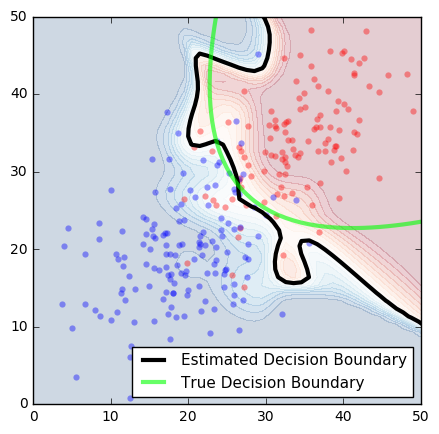

In [31]:
selected_bw = 2#"""number for bandwidth"""

fig, ax = plt.subplots(1,1, figsize=(5,5))

p_x_red = run_kde(Gaussian1['data'], bandwidth=selected_bw, metric='euclidean', kernel='gaussian')
p_x_blue = run_kde(Gaussian2['data'], bandwidth=selected_bw, metric='euclidean', kernel='gaussian')

# Posterior probability 
p_red_x_ = p_x_red * p_red
p_blue_x_ = p_x_blue * p_blue
denom = p_red_x_ + p_blue_x_

p_red_x = p_red_x_ / denom #"""Equation for posterior probability"""
p_blue_x = p_blue_x_ / denom # """Equation for posterior probability"""

levels = np.linspace(p_blue_x.min(), p_blue_x.max(), 20)
ax.contourf(X, Y, p_blue_x, levels=levels, cmap='RdBu', alpha=0.2)

# Data points
ax.scatter(Gaussian1['data'][:,0], Gaussian1['data'][:,1], linewidth=0, color='red', alpha=0.4)
ax.scatter(Gaussian2['data'][:,0], Gaussian2['data'][:,1], linewidth=0, color='blue', alpha=0.4)

# Estimated decision boundary
ax.contour(X, Y, p_red_x - p_blue_x, levels=[0.0], 
           colors='black', linewidths=3)
# True decision boundary
ax.contour(X, Y, p_red_x_true - p_blue_x_true, levels=[0.0], alpha=0.6,
           colors='lime', linewidths=3, labels='True Decision Boundary')

# Below lines are for legend creation.
ax.plot([],[], color='black', linewidth=3, label='Estimated Decision Boundary')
ax.plot([],[], color='lime', linewidth=3, alpha=0.6, label='True Decision Boundary')
ax.legend(loc='lower right', fontsize=11)
ax.set_xlim(0,nX)
ax.set_ylim(0,nY)

If you were able to fill in the previous part, you can use a for loop below to plot two different cases in one figure. We're going to have three subplots with small, medium, and large bandwidth. Fill in the parts that are missing (parts that are commented out with three double quotes `"""`).

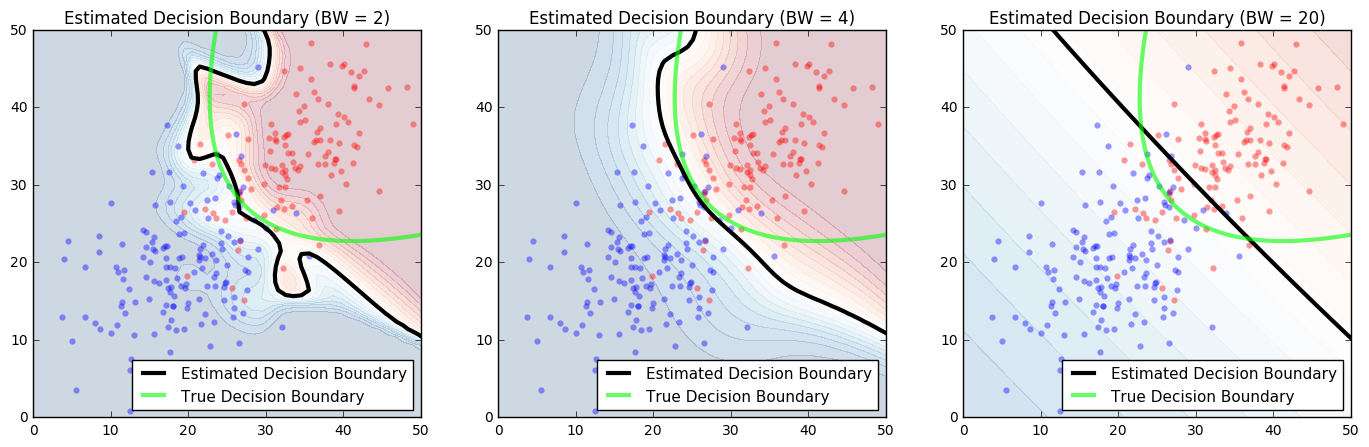

In [32]:
small_bw = 2 #"""Integer value for small BW"""
med_bw = 4
large_bw = 20 # """Integer value for large BW"""
bandwidth_list = [small_bw, med_bw, large_bw]

fig, axs = plt.subplots(1,3, figsize=(17,5))

for bw, ax in zip(bandwidth_list, axs):

    p_x_red = run_kde(Gaussian1['data'], bandwidth=bw, metric='euclidean', kernel='gaussian')
    p_x_blue = run_kde(Gaussian2['data'], bandwidth=bw, metric='euclidean', kernel='gaussian')

    # Posterior probability 
    p_red_x_ = p_x_red * p_red
    p_blue_x_ = p_x_blue * p_blue
    denom = p_red_x_ + p_blue_x_

    p_red_x = p_red_x_ / denom #"""Equation for posterior probability"""
    p_blue_x = p_blue_x_ / denom # """Equation for posterior probability"""
    
    levels = np.linspace(p_blue_x.min(), p_blue_x.max(), 20)
    ax.contourf(X, Y, p_blue_x, levels=levels, cmap='RdBu', alpha=0.2)
    
    # Data points
    ax.scatter(Gaussian1['data'][:,0], Gaussian1['data'][:,1], linewidth=0, color='red', alpha=0.4)
    ax.scatter(Gaussian2['data'][:,0], Gaussian2['data'][:,1], linewidth=0, color='blue', alpha=0.4)

    ax.contour(X, Y, p_red_x- p_blue_x, levels=[0.0], 
               colors='black', linewidths=3)
    ax.contour(X, Y, p_red_x_true- p_blue_x_true, levels=[0.0], alpha=0.6,
               colors='lime', linewidths=3, labels='True Decision Boundary')
    
    ax.set_title('Estimated Decision Boundary (BW = %d)' % bw)

    # Below lines are for legend creation.
    ax.plot([],[], color='black', linewidth=3, label='Estimated Decision Boundary')
    ax.plot([],[], color='lime', linewidth=3, alpha=0.6, label='True Decision Boundary')
    ax.legend(loc='lower right', fontsize=11)
    ax.set_xlim(0,nX)
    ax.set_ylim(0,nY)

### EXERCISE (OPTIONAL)
### Decision boundary when the sample size is small or large

Generate two sets of data from each Gaussian1 and Gaussian2, one with small sample size `N`, and one with large sample size `N`.

Re-estimate the density from KDE with data of different sample sizes, and plot the decision boundaries. Fill in the parts that are missing (parts that are commented out with three double quotes : `"""`).

In [38]:
# Generate the data set with different sample sizes. 

# Gaussian 1
seed(1)
m = Gaussian1['mean']
cov = Gaussian1['cov']

N = Gaussian1['N'] // 5
data = multivariate_normal(m, cov, size=N)
Gaussian1_smallN = {'mean':m, 'cov':cov, 'N':N, 'data':data}

N = Gaussian1['N'] * 20
data = multivariate_normal(m, cov, size=N)
Gaussian1_largeN = {'mean':m, 'cov':cov, 'N':N, 'data':data}


# Gaussian 2
m = Gaussian2['mean']
cov = Gaussian2['cov']

N = Gaussian1['N'] // 5
data = multivariate_normal(m, cov, size=N)
Gaussian2_smallN = {'mean':m, 'cov':cov, 'N':N, 'data':data}

N = Gaussian1['N'] * 20
data = multivariate_normal(m, cov, size=N)
Gaussian2_largeN = {'mean':m, 'cov':cov, 'N':N, 'data':data}


We're going to have 3 subplots: for small N, medium N, large N

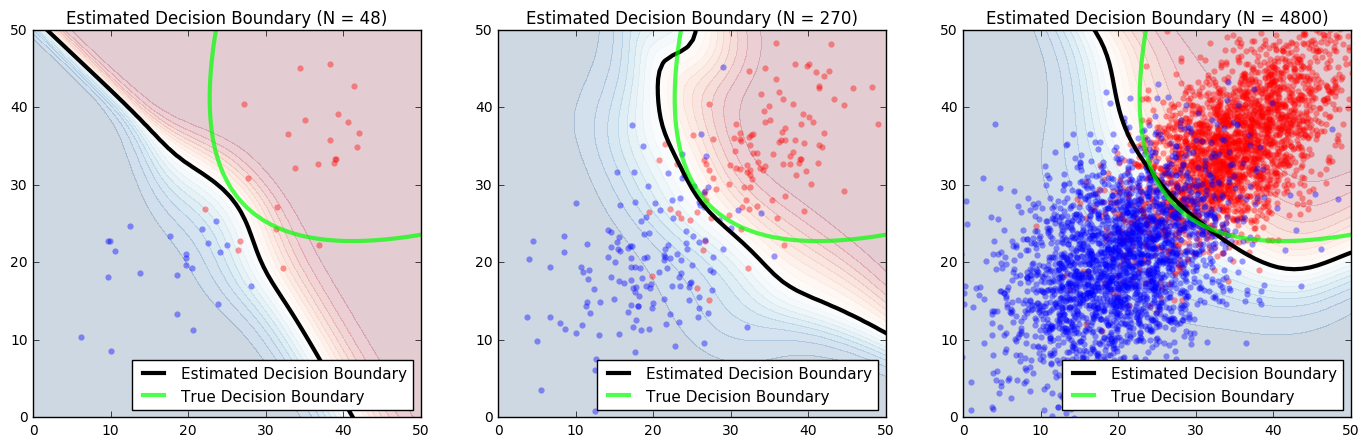

In [39]:
data_list = [[Gaussian1_smallN, Gaussian2_smallN], 
             [Gaussian1, Gaussian2], 
             [Gaussian1_largeN, Gaussian2_largeN]]

fig, axs = plt.subplots(1,3, figsize=(17,5))

for Gaussians, ax in zip(data_list, axs):

    g1_data = Gaussians[0]['data']
    g2_data = Gaussians[1]['data']
    sample_size_N = Gaussians[0]['N'] + Gaussians[1]['N']
    
    p_x_red = run_kde(g1_data, bandwidth=4, metric='euclidean', kernel='gaussian')#"""Fill in the parenthesis using variable g1_data""")
    p_x_blue = run_kde(g2_data, bandwidth=4, metric='euclidean', kernel='gaussian')#"""Fill in the parenthesis using variable g2_data """)

    # Posterior 
    p_red_x_ = p_x_red * p_red
    p_blue_x_ = p_x_blue * p_blue
    denom = p_red_x_ + p_blue_x_

    p_red_x = p_red_x_ / denom #"""Equation for posterior probability"""
    p_blue_x = p_blue_x_ / denom # """Equation for posterior probability"""

    levels = np.linspace(p_blue_x.min(), p_blue_x.max(), 20)
    ax.contourf(X, Y, p_blue_x, levels=levels, cmap='RdBu', alpha=0.2)
    
    # Data points
    ax.scatter(Gaussians[0]['data'][:,0], Gaussians[0]['data'][:,1], linewidth=0, color='red', alpha=0.4)
    ax.scatter(Gaussians[1]['data'][:,0], Gaussians[1]['data'][:,1], linewidth=0, color='blue', alpha=0.4)

    # Contour plot
    ax.contour(X, Y, p_red_x- p_blue_x, levels=[0.0], 
               colors='black', linewidths=3)
    ax.contour(X, Y, p_red_x_true- p_blue_x_true, levels=[0.0], alpha=0.7,
               colors='lime', linewidths=3, labels='True Decision Boundary')
    
    ax.set_title('Estimated Decision Boundary (N = %d)' % sample_size_N)

    # Below lines are for the legend creation.
    ax.plot([],[], color='black', linewidth=3, label='Estimated Decision Boundary')
    ax.plot([],[], color='lime', linewidth=3, alpha=0.7, label='True Decision Boundary')
    ax.legend(loc='lower right', fontsize=11)
    
    ax.set_xlim(0,nX)
    ax.set_ylim(0,nY)